In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import scipy.ndimage as ndimage
from skimage.morphology import ball, binary_closing, remove_small_objects, binary_dilation, binary_erosion

c:\Users\DELL\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [2]:
path_to_data = "../results/femur_tibia_mask.nii.gz"

In [3]:
mask_vol = nib.load(path_to_data)
mask_vol


In [4]:
print(mask_vol.header)


<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 512 512 216   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1.       0.869141 0.869141 2.       1.       1.       1.       1.      ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : 222.5
qoffset_y       : 222.5
qoffset_z       : -900.5
sro

Summary of Segmentation Mask
Shape: (512, 512, 216) → 216 axial slices of 512×512 pixels

Voxel size: (0.869 × 0.869 × 2.0 mm³) 

Datatype: 8-bit unsigned integer (uint8) — suitable for labeled masks

Physical size of volume (approx.):

Width: 512 × 0.869 mm ≈ 445 mm

Height: 512 × 0.869 mm ≈ 445 mm

Depth: 216 × 2.0 mm = 432 mm


In [5]:
mask = mask_vol.get_fdata() # get image array data
affine = mask_vol.affine # gets affine transformation matrix associated with the volume data
affine


array([[-8.69140983e-01,  0.00000000e+00,  0.00000000e+00,
         2.22500000e+02],
       [ 0.00000000e+00, -8.69140983e-01,  0.00000000e+00,
         2.22500000e+02],
       [ 0.00000000e+00,  0.00000000e+00,  2.00000000e+00,
        -9.00500000e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

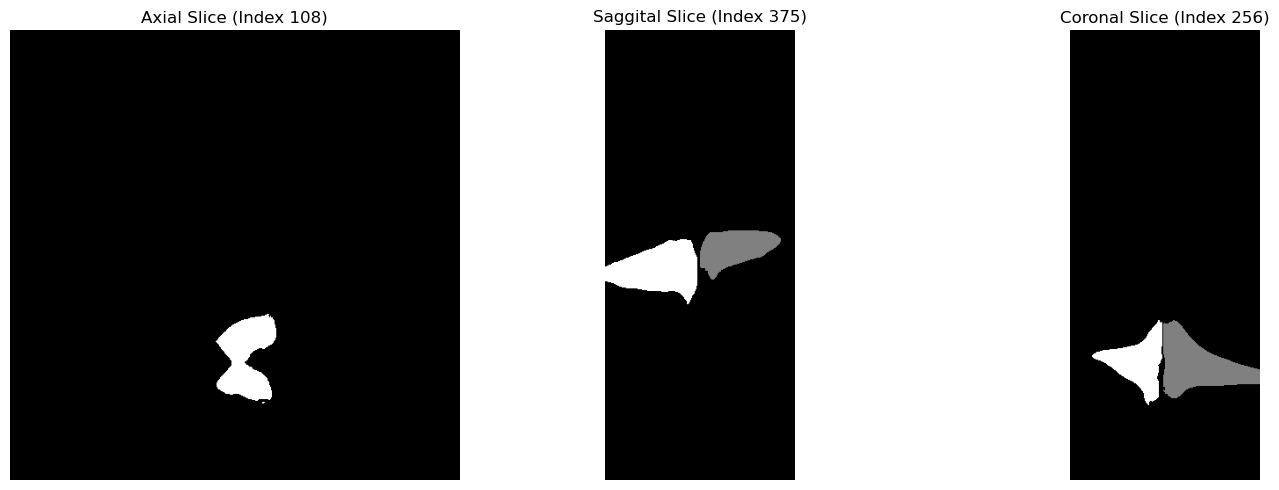

In [6]:
def plot_slices(data):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Axial slice 
    axes[0].imshow(data[:, :, 108], cmap='gray')
    axes[0].set_title('Axial Slice (Index 108)')
    axes[0].axis('off')

    # Coronal slice
    axes[1].imshow(data[375, :, :], cmap='gray')
    axes[1].set_title('Saggital Slice (Index 375)')
    axes[1].axis('off')
    # Sagittal slice
    axes[2].imshow(data[:, 256, :], cmap='gray')
    axes[2].set_title('Coronal Slice (Index 256)')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

plot_slices(mask)


Extract tibia from the bone

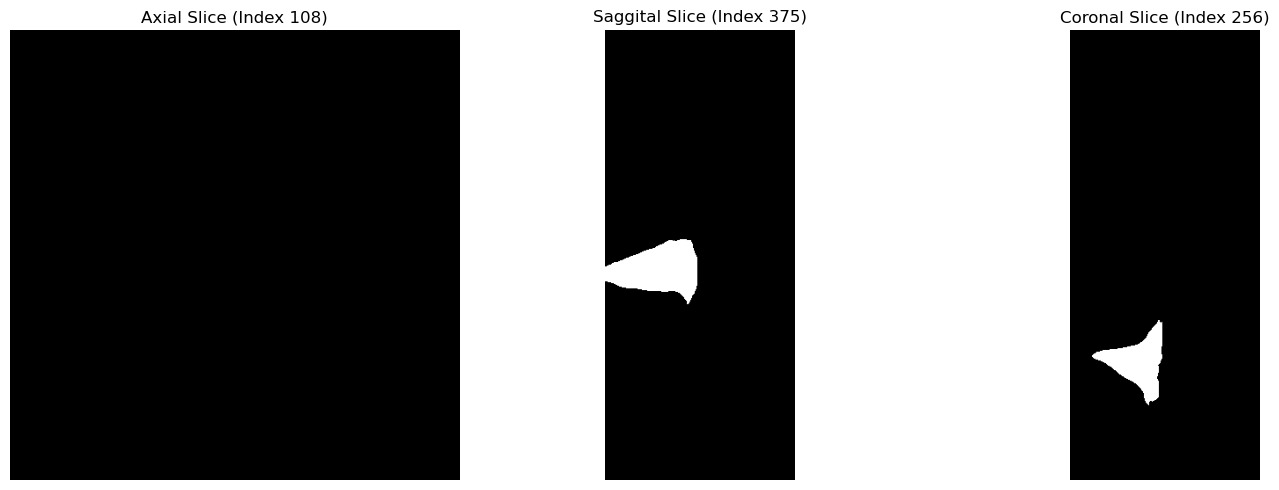

In [7]:
tibia_mask = (mask == 2)

plot_slices(tibia_mask)


In [8]:
from pathlib import Path

labelled_mask = tibia_mask.astype(np.uint8)  # NIfTI format expects int types

nii_mask = nib.Nifti1Image(labelled_mask, affine=mask_vol.affine)

nib.save(nii_mask, Path("../results")/"task_4_tibia_mask.nii.gz")


Tibia Mask Expansion (2 mm)

In [9]:
def get_voxel_spacing(affine):
    spacing_x = np.linalg.norm(affine[:3, 0])
    spacing_y = np.linalg.norm(affine[:3, 1])
    spacing_z = np.linalg.norm(affine[:3, 2])
    return spacing_x, spacing_y, spacing_z

spacing = get_voxel_spacing(affine)
print(f"Voxel spacing (mm): {spacing}")


Voxel spacing (mm): (0.8691409826278687, 0.8691409826278687, 2.0)


In [10]:
# calculate how many voxels we need to expand by 2 mm
def calculate_expansion_voxels(spacing, expansion_mm=2):
    radius_voxels = [int(np.ceil(expansion_mm / s)) for s in spacing]
    return radius_voxels

calculate_expansion_voxels(spacing)


[3, 3, 1]

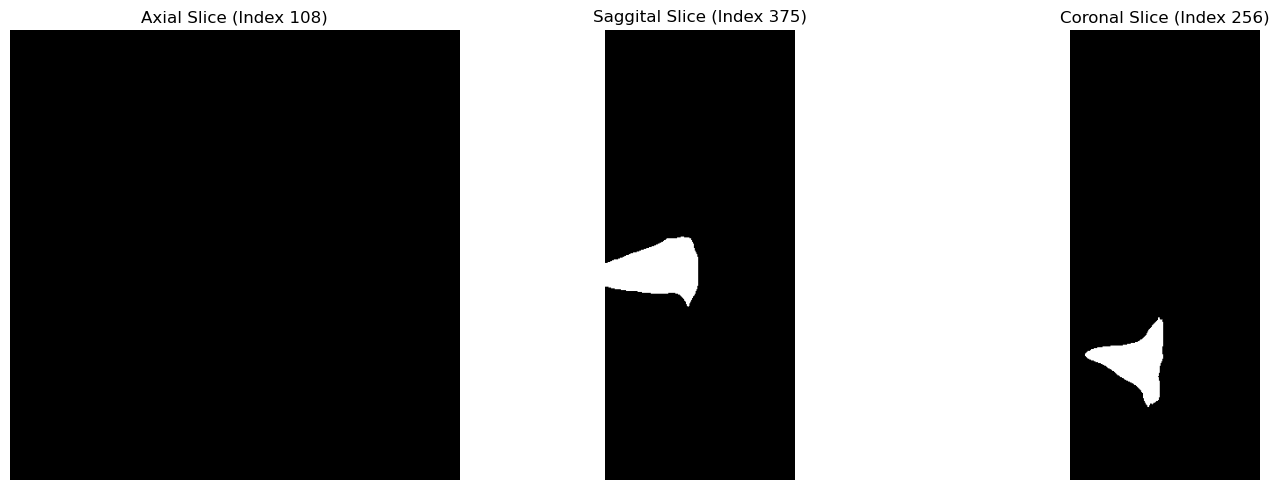

In [11]:
from scipy.ndimage import distance_transform_edt



def expand_mask(mask, spacing, expansion_mm):
    # Compute distance transform of the background (~mask)
    distance = distance_transform_edt(~mask, sampling=spacing)
    # Include original mask plus points within expansion_mm
    expanded = mask | (distance <= expansion_mm)
    return expanded

tibia_expanded = expand_mask(tibia_mask, spacing, 2)

expanded_mask = np.zeros_like(mask)
expanded_mask[tibia_expanded] = 2



plot_slices(expanded_mask)


In [12]:
expanded_img = nib.Nifti1Image(expanded_mask.astype(np.uint8), mask_vol.affine, mask_vol.header)
nib.save(expanded_img, Path("../results")/'task4_tibia_mask_expanded_2mm.nii.gz')


Expand Mask by 4 mm

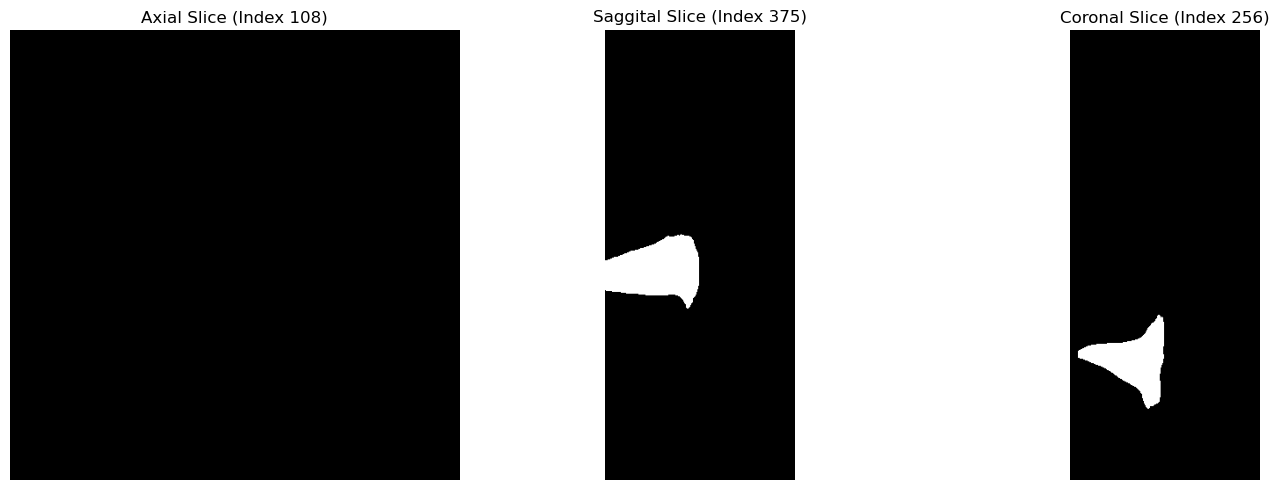

In [13]:

tibia_expanded = expand_mask(tibia_mask, spacing, 4)

expanded_mask_4mm = np.zeros_like(mask)
expanded_mask_4mm[tibia_expanded] = 2

plot_slices(expanded_mask_4mm)

In [14]:
expanded_img = nib.Nifti1Image(expanded_mask_4mm.astype(np.uint8), mask_vol.affine, mask_vol.header)
nib.save(expanded_img, Path("../results")/'task4_tibia_mask_expanded_4mm.nii.gz')


Randmized contour adjustment - tibia mask

In [15]:
def randomized_contour_adjustment(original_mask, spacing, expansion_mm, seed):
   
    if seed is not None:
        np.random.seed(seed)
    
    # 1) distance (in mm) from each background voxel to original mask
    #    distance[i,j,k] = min distance (mm) to a True voxel in original_mask
    distance = distance_transform_edt(
        ~original_mask,
        sampling=spacing
    )
    
    # 2) draw a random expansion radius for *every* voxel in the volume
    #    range [0, expansion_mm]
    random_offsets = np.random.rand(*original_mask.shape) * expansion_mm
    
    # 3) build the new mask:
    #    - keep all original voxels
    #    - add background voxels only if distance <= that voxel’s random offset
    randomized = original_mask | (
        (distance <= random_offsets) &
        (~original_mask)
    )
    
    return randomized

# ---------------------------------------------------------------------
# Example usage for femur and tibia:

# assume you already have:
#   mask          : int32 ndarray with labels {0,1,2}
#   spacing       : (0.89, 0.89, 2.0)
#   expansion_mm  : 2.0

# First randomized adjustment (seed=42)
tibia_rand1 = randomized_contour_adjustment(tibia_mask, spacing, 2.0, seed=42)

# Second randomized adjustment (different seed)
tibia_rand2 = randomized_contour_adjustment(tibia_mask, spacing, 2.0, seed=99)

# Combine into labeled masks
rand_mask1 = np.zeros_like(mask, dtype=np.int32)
rand_mask1[tibia_rand1] = 2

rand_mask2 = np.zeros_like(mask, dtype=np.int32)
rand_mask2[tibia_rand2] = 2

# Now you have:
#  • rand_mask1  – the first randomized expansion
#  • rand_mask2  – the second randomized expansion
# both lying between original and +2 mm, never shrinking below original.



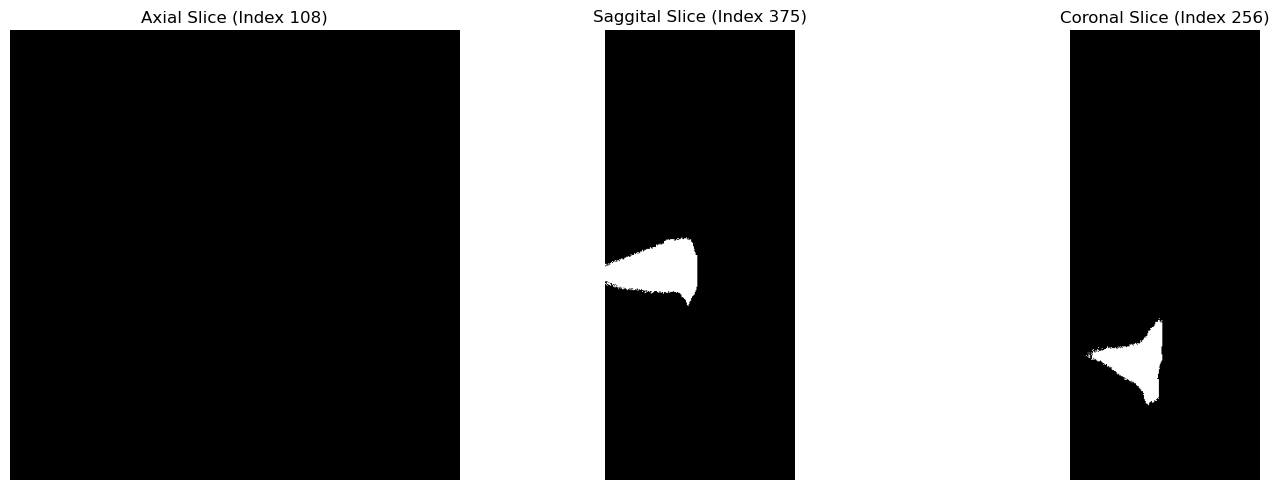

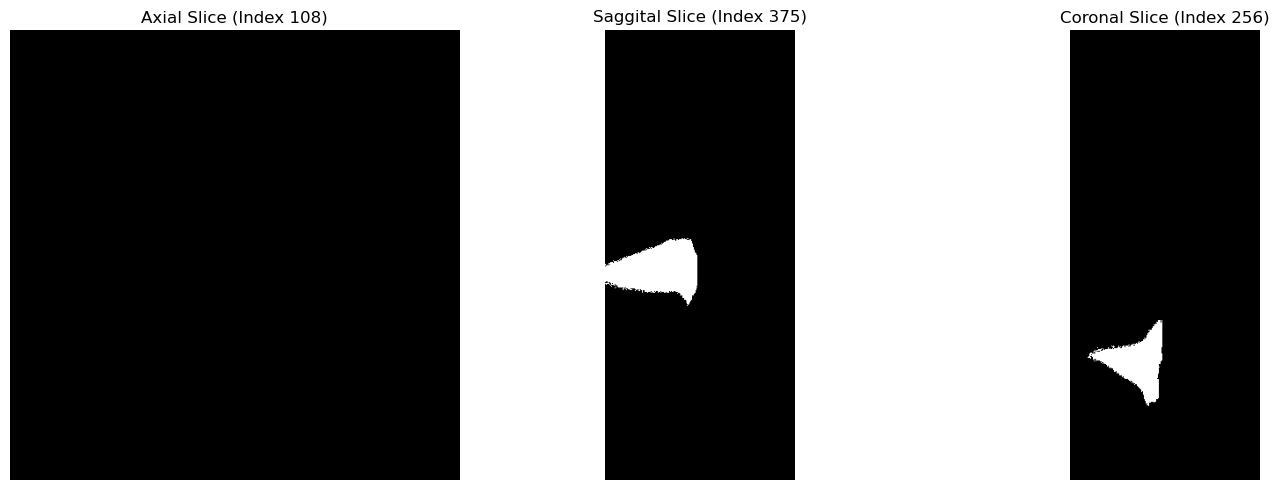

In [16]:
plot_slices(rand_mask1)
plot_slices(rand_mask2)

In [17]:
missing_tibia = tibia_mask & (~rand_mask1.astype(bool))
print(f"Missing tibia voxels in randomized mask: {np.sum(missing_tibia)}")



Missing tibia voxels in randomized mask: 0


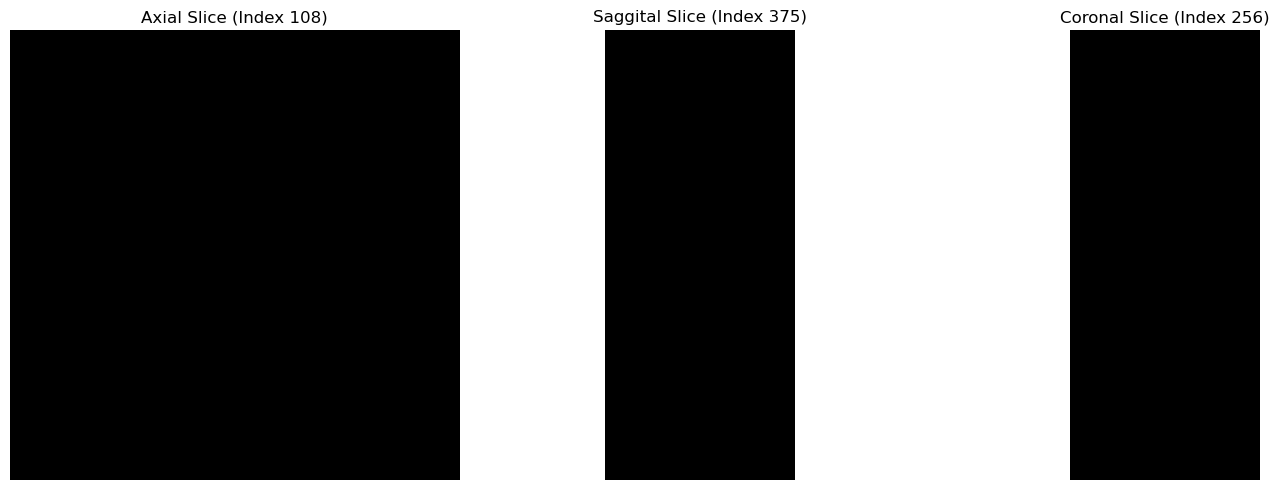

In [18]:
original_tibia = (mask == 2)
randomized_tibia = (rand_mask1 == 2)
missing_tibia = original_tibia & (~randomized_tibia)
plot_slices(missing_tibia)


In [19]:
rand_1_img = nib.Nifti1Image(rand_mask1.astype(np.uint8), mask_vol.affine, mask_vol.header)
nib.save(rand_1_img, Path("../results")/'task4_randomized_mask_1.nii.gz')


In [20]:
rand_2_img = nib.Nifti1Image(rand_mask2.astype(np.uint8), mask_vol.affine, mask_vol.header)
nib.save(rand_2_img, Path("../results")/'task4_randomized_mask_2.nii.gz')


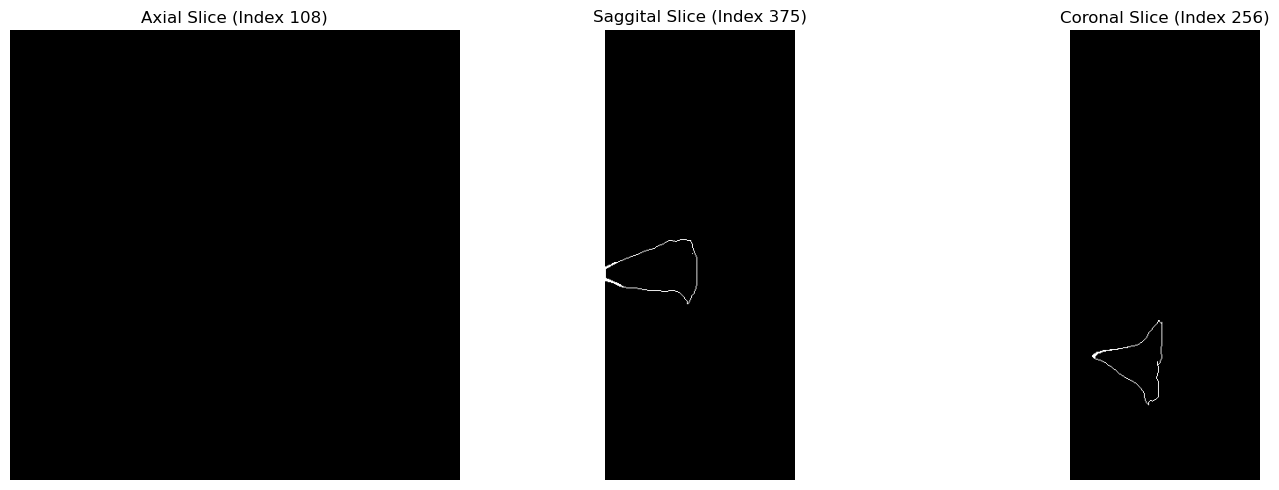

In [21]:
from scipy.ndimage import binary_erosion
eroded = binary_erosion(tibia_mask)
surface = tibia_mask & (~eroded)

plot_slices(surface)


In [22]:
import nibabel as nib
import numpy as np
from skimage.measure import marching_cubes
import os

def get_surface_points(mask):
    # Use marching cubes to extract surface points
    verts, faces, normals, _ = marching_cubes(mask, level=0.5)
    return verts

def find_medial_lateral_lowest_points(verts):
    # Split by midline along x-axis (adjust axis if needed)
    midline = np.median(verts[:, 0])
    medial = verts[verts[:, 0] < midline]
    lateral = verts[verts[:, 0] >= midline]

    medial_lowest = medial[np.argmin(medial[:, 2])]  # lowest z
    lateral_lowest = lateral[np.argmin(lateral[:, 2])]  # lowest z

    return medial_lowest, lateral_lowest

def process_mask(file_path):
    # Load mask
    mask_nii = nib.load(file_path)
    mask = mask_nii.get_fdata()
    affine = mask_nii.affine
    
    world_coord = np.array([0, 0, -750, 1])
    inv_affine = np.linalg.inv(affine)
    voxel_coord = inv_affine @ world_coord
    voxel_z_cutoff = voxel_coord[2]
    # Get surface and find landmarks
    verts = get_surface_points(mask)
    proximal_verts = verts[verts[:, 2] > voxel_z_cutoff]

    medial, lateral = find_medial_lateral_lowest_points(proximal_verts)

    # Convert from voxel to world coordinates
    medial_world = nib.affines.apply_affine(affine, medial)
    lateral_world = nib.affines.apply_affine(affine, lateral)
    verts_world = nib.affines.apply_affine(affine, proximal_verts)
    return medial_world, lateral_world, verts_world


In [23]:
medial_world, lateral_world, verts = process_mask("../results/task_4_tibia_mask.nii.gz")

In [24]:
medial_world, lateral_world, verts

(array([ -79.09192097,  -11.29892433, -749.5       ]),
 array([-106.90443242,  -34.76573086, -749.5       ]),
 array([[ -56.92882591,  -13.03720629, -700.5       ],
        [ -57.36339641,  -13.03720629, -701.5       ],
        [ -57.36339641,  -12.6026358 , -700.5       ],
        ...,
        [-151.66519302,  -27.812603  , -710.5       ],
        [-151.66519302,  -28.68174398, -712.5       ],
        [-151.66519302,  -28.68174398, -710.5       ]]))

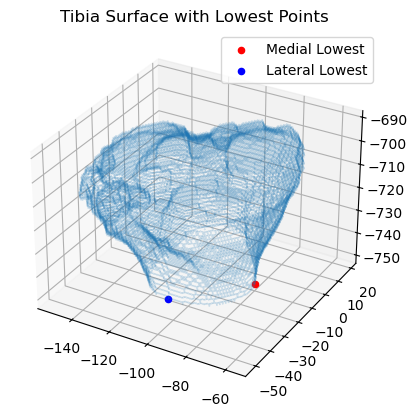

In [25]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Show tibia surface
ax.scatter(verts[:, 0], verts[:, 1], verts[:, 2], s=0.1, alpha=0.3)

# Overlay lowest points (in voxel coordinates or apply inverse transform if needed)
ax.scatter(*medial_world[:3], color='red', label='Medial Lowest')
ax.scatter(*lateral_world[:3], color='blue', label='Lateral Lowest')

ax.set_title("Tibia Surface with Lowest Points")
ax.legend()
plt.show()


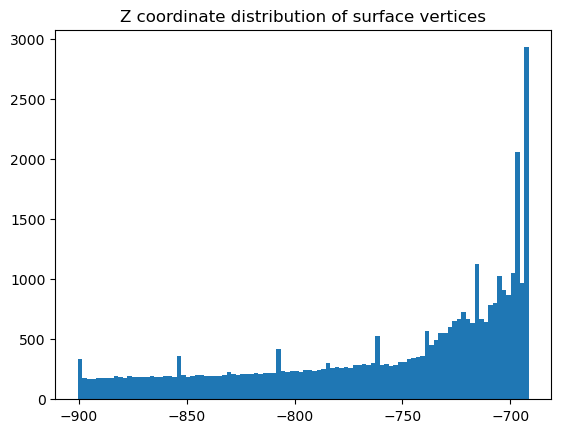

In [75]:
# verts = your surface vertices (N, 3) in voxel or world coords

# Visualize Z distribution
import matplotlib.pyplot as plt
plt.hist(verts[:, 2], bins=100)
plt.title('Z coordinate distribution of surface vertices')
plt.show()

# Pick cutoff manually from histogram, e.g. z_cutoff = -750 (world units)
proximal_verts = verts[verts[:, 2] > -750]

# Then proceed with medial/lateral split and lowest point search on proximal_verts


In [119]:
pip install pyvista


   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
    --------------------------------------- 0.0/2.4 MB 1.9 MB/s eta 0:00:02
   -- ------------------------------------- 0.1/2.4 MB 2.1 MB/s eta 0:00:02
   ---- ----------------------------------- 0.3/2.4 MB 3.1 MB/s eta 0:00:01
   --------- ------------------------------ 0.6/2.4 MB 3.5 MB/s eta 0:00:01
   -------------------- ------------------- 1.2/2.4 MB 6.0 MB/s eta 0:00:01
   -------------------------------------- - 2.3/2.4 MB 9.3 MB/s eta 0:00:01
   ---------------------------------------- 2.4/2.4 MB 9.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/58.4 MB ? eta -:--:--
    --------------------------------------- 1.0/58.4 MB 33.4 MB/s eta 0:00:02
    --------------------------------------- 1.0/58.4 MB 33.4 MB/s eta 0:00:02
    --------------------------------------- 1.0/58.4 MB 33.4 MB/s eta 0:00:02
    --------------------------------------- 1.0/58.4 MB 33.4 MB/s eta 0:00:02
    -------------

In [ ]:
import nibabel as nib
import numpy as np
import pyvista as pv
from skimage.measure import marching_cubes

def get_surface_mesh(mask):
    # Extract surface mesh from mask (voxel coords)
    verts, faces, normals, values = marching_cubes(mask, level=0.5)
    faces = np.hstack([np.full((faces.shape[0], 1), 3), faces]).astype(np.int64)
    mesh = pv.PolyData(verts, faces)
    return mesh

def isolate_plateau_by_curvature(mesh, curvature_threshold=0.01):
    curvature = mesh.curvature(curv_type='mean')
    mesh['curvature'] = curvature

    # Get min curvature value to use as lower bound
    min_curv = curvature.min()

    # Threshold between min curvature and the curvature_threshold (upper bound)
    plateau = mesh.threshold(value=(min_curv, curvature_threshold))
    return plateau


def find_medial_lateral_lowest_points(mesh):
    verts = mesh.points
    midline = np.median(verts[:, 0])
    medial = verts[verts[:, 0] < midline]
    lateral = verts[verts[:, 0] >= midline]

    medial_lowest = medial[np.argmin(medial[:, 2])]
    lateral_lowest = lateral[np.argmin(lateral[:, 2])]
    return medial_lowest, lateral_lowest

def process_mask(file_path, curvature_threshold=0.01):
    # Load mask and affine
    mask_nii = nib.load(file_path)
    mask = mask_nii.get_fdata()
    affine = mask_nii.affine

    # Extract surface mesh from mask
    mesh = get_surface_mesh(mask)

    # Isolate plateau by curvature thresholding
    plateau_mesh = isolate_plateau_by_curvature(mesh, curvature_threshold)

    # Find medial and lateral lowest points on plateau mesh
    medial, lateral = find_medial_lateral_lowest_points(plateau_mesh)

    # Convert points from voxel to world coordinates
    medial_world = nib.affines.apply_affine(affine, medial)
    lateral_world = nib.affines.apply_affine(affine, lateral)

    return medial_world, lateral_world, plateau_mesh

# Example usage:
file_path = 'tibia_mask.nii.gz'
medial_point, lateral_point, plateau_mesh = process_mask("../results/task_4_tibia_mask.nii.gz", curvature_threshold=0.01)

print("Medial lowest point (world):", medial_point)
print("Lateral lowest point (world):", lateral_point)

# Visualization (optional)
plotter = pv.Plotter()
plotter.add_mesh(plateau_mesh, color='lightblue', opacity=0.5)
plotter.add_mesh(pv.Sphere(radius=1, center=medial_point), color='red', label='Medial Lowest')
plotter.add_mesh(pv.Sphere(radius=1, center=lateral_point), color='blue', label='Lateral Lowest')
plotter.add_legend()
plotter.show()


TypeError: '>' not supported between instances of 'NoneType' and 'float'